# optimizing vision transformer model for deployment

    将自然语言处理中的基于注意力的transformer模型应用于计算机视觉任务，用来实现各种SOTA(state of the art)结果。
    https://pytorch.org/tutorials/beginner/vt_tutorial.html

## DeiT
    DeiT与CNN相比只需要较少的数据和计算资源，主要通过DeiT的两个关键组件得以实现：
    1、Data augmentation that simulates training on a much larger dataset;
    2、Native distillation that allows the transformer network to learn from a CNN’s output.
    

## 用DeiT对图像进行分类
安装所需的软件包

`
pip install torch torchvision
pip install timm
pip install pandas
pip install requests
`
注意：需要安装timm版本 0.3.2
https://github.com/facebookresearch/deit

In [3]:
from PIL import Image
import torch
import timm
import requests
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

print(torch.__version__)
# should be 1.8.0

# To load DeiT-base with pretrained weights on ImageNet simply do
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)
img = transform(img)[None,]
out = model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

1.8.0a0+bee6b0b


Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

/root/anaconda3/envs/ts_env/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


269


### 脚本编制
要在移动设备上使用模型，我们首先需要编写模型脚本；

运行以下代码，将上一步中使用的DeiT模型转换为可以在移动设备上运行的TorchScript格式。

In [4]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("models/fbdeit_scripted.pt")

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


### 量化 DeiT
显著减小模型大小，同时保持推理大致精度。可对模型进行动态量化。

In [5]:
# Use 'fbgemm' for server inference and 'qnnpack' for mobile inference
backend = "fbgemm" # replaced with qnnpack causing much worse inference speed for quantized model on this notebook
model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("models/fbdeit_scripted_quantized.pt")

In [6]:
# 生成相同的推理结果
out = scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())
# The same output 269 should be printed

269


### 优化 DeiT

In [8]:
from torch.utils.mobile_optimizer import optimize_for_mobile
optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("models/fbdeit_optimized_scripted_quantized.pt")

In [9]:
# 推理结果保持不变
out = optimized_scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())
# Again, the same output 269 should be printed

269


/root/anaconda3/envs/ts_env/lib/python3.7/site-packages/torch/nn/modules/module.py:881: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /root/public/pytorch/c10/core/TensorImpl.h:890.)
  result = self.forward(*input, **kwargs)


### Using Lite Interpreter
继续简化; 移动设备上运行时，预计推理速度会加快。

In [10]:
optimized_scripted_quantized_model._save_for_lite_interpreter("models/fbdeit_optimized_scripted_quantized_lite.ptl")
ptl = torch.jit.load("models/fbdeit_optimized_scripted_quantized_lite.ptl")

### Comparing Inference Speed
四种模型：

原始模型(pth)；/root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth

Scripted 模型(fbdeit_scripted.pt);

quantized-and-scripted 模型(fbdeit_scripted_quantized.pt);

 optimized-quantized-and-scripted 模型(fbdeit_optimized_scripted_quantized.pt);

In [24]:
with torch.autograd.profiler.profile(use_cuda=False) as prof1:
    out = model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof2:
    out = scripted_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof3:
    out = scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof4:
    out = optimized_scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof5:
    out = ptl(img)

print("original model: {:.2f}ms".format(prof1.self_cpu_time_total/1000))
print("scripted model: {:.2f}ms".format(prof2.self_cpu_time_total/1000))
print("scripted & quantized model: {:.2f}ms".format(prof3.self_cpu_time_total/1000))
print("scripted & quantized & optimized model: {:.2f}ms".format(prof4.self_cpu_time_total/1000))
print("lite model: {:.2f}ms".format(prof5.self_cpu_time_total/1000))

original model: 23600.66ms
scripted model: 24021.99ms
scripted & quantized model: 371.29ms
scripted & quantized & optimized model: 495.42ms
lite model: 444.15ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(224, 224, 3)


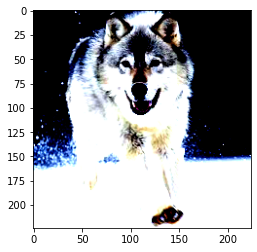

In [23]:
# 图片显示
from matplotlib import pyplot as plt
import cv2
import numpy as np

test_img = img[0].numpy()
print(test_img.shape)
test_img = np.transpose(test_img, (1, 2, 0))
print(test_img.shape)
plt.imshow(test_img)
plt.show()

In [26]:
# 每个模型的推理时间以及每个模型相对于原始模型的减少百分比
import pandas as pd
import numpy as np

df = pd.DataFrame({'Model': ['original model','scripted model', 'scripted & quantized model', 'scripted & quantized & optimized model', 'lite model']})
df = pd.concat([df, pd.DataFrame([
    ["{:.2f}ms".format(prof1.self_cpu_time_total/1000), "0%"],
    ["{:.2f}ms".format(prof2.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof2.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof3.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof3.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof4.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof4.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof5.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof5.self_cpu_time_total)/prof1.self_cpu_time_total*100)]],
    columns=['Inference Time', 'Reduction'])], axis=1)

print(df)

"""
                                    Model Inference Time Reduction
0                          original model     23600.66ms        0%
1                          scripted model     24021.99ms    -1.79%
2              scripted & quantized model       371.29ms    98.43%
3  scripted & quantized & optimized model       495.42ms    97.90%
4                              lite model       444.15ms    98.12%
"""

                                    Model Inference Time Reduction
0                          original model     23600.66ms        0%
1                          scripted model     24021.99ms    -1.79%
2              scripted & quantized model       371.29ms    98.43%
3  scripted & quantized & optimized model       495.42ms    97.90%
4                              lite model       444.15ms    98.12%


'\n                                    Model Inference Time Reduction\n0                          original model     23600.66ms        0%\n1                          scripted model     24021.99ms    -1.79%\n2              scripted & quantized model       371.29ms    98.43%\n3  scripted & quantized & optimized model       495.42ms    97.90%\n4                              lite model       444.15ms    98.12%\n'